In [2]:
import pandas as pd
import seaborn as sns 
from pandas import DataFrame
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import LabelEncoder
import numpy as np
import plotly
import statistics
import plotly.express as px
import stats
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score
import plotly.express as px
import datetime
import datetime as dt
import time
import django.template.backends.jinja2

Opening file 

In [3]:
#ein impfstoff aber, hat keiner Nationalität 

# Supress Scientific notation in python
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Display all columns of long dataframe
pd.set_option('display.max_columns', None)

# open cohort

vax_path='vaccinations.csv'
vax=pd.read_csv(vax_path)
#print(vax)


Romania=vax[vax.country=='Romania']
Germany=vax[vax.country=='Germany']

Time series

In [4]:
#parse index
vax['date']=pd.to_datetime(vax['date'], infer_datetime_format=True)
indexeddf=vax.set_index(['date'])
#print(indexeddf)

#parsing to time format and extracting dates with 'created_at'
x=vax['date']=pd.to_datetime(vax['date'], format='%d-%m-%y')

Day=vax['date'].dt.day_name()
Month=vax['date'].dt.month_name()
Year=vax['date'].dt.year

#subsetting 
vax['Year']=vax['date'].dt.year
vax['Month']=vax['date'].dt.month_name()
vax['Day']=vax['date'].dt.day_name()
print(vax)

          country iso_code       date  total_vaccinations  people_vaccinated  \
0     Afghanistan      AFG 2021-02-22                   0                  0   
1     Afghanistan      AFG 2021-02-23                   0                  0   
2     Afghanistan      AFG 2021-02-24                   0                  0   
3     Afghanistan      AFG 2021-02-25                   0                  0   
4     Afghanistan      AFG 2021-02-26                   0                  0   
...           ...      ...        ...                 ...                ...   
6993     Zimbabwe      ZWE 2021-03-13               36359              36359   
6994     Zimbabwe      ZWE 2021-03-14               36359              36359   
6995     Zimbabwe      ZWE 2021-03-15               37660              37660   
6996     Zimbabwe      ZWE 2021-03-16               39550              39550   
6997     Zimbabwe      ZWE 2021-03-17               39607              39607   

      people_fully_vaccinated  daily_va

Cohort Month

In [5]:

#create cohort month 
def get_month(x):
    return dt.datetime (x.year, x.month, 1)

vax['VaxedMonth']=vax['date'].apply(get_month)
grouping=vax.groupby('iso_code')['VaxedMonth']
vax['CohortMonth']=grouping.transform('min')

In [6]:

# calculate time offsets

def get_month_int(cohortframe, column):
    year=cohortframe[column].dt.year
    month=cohortframe[column].dt.month
    day=cohortframe[column].dt.day
    return year, month, day

#call function 
vaxed_year, vaxed_month, vaxed_day_=get_month_int(vax,'VaxedMonth')
cohort_year, cohort_month,cohort_day_=get_month_int(vax,'CohortMonth')

#create year an month diffs
year_diff=vaxed_year-cohort_year
month_diff=vaxed_month-cohort_month
day_diff=vaxed_day_ - cohort_day_

#create cohortindex
vax['CohortIndex']=year_diff * 12 + month_diff +1 + day_diff +7

Counting monthly cohorts

In [7]:
#count monthly cohs

grouping = vax.groupby(['VaxedMonth', 'CohortIndex'])
cohort_data = grouping['iso_code'].apply(pd.Series.nunique)

#return number of unique vals
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='VaxedMonth', columns='CohortIndex', values='iso_code')
print(cohort_counts)

CohortIndex    8     9     10    11
VaxedMonth                         
2020-12-01  45.00   nan   nan   nan
2021-01-01  40.00 45.00   nan   nan
2021-02-01  46.00 38.00 45.00   nan
2021-03-01  12.00 40.00 33.00 45.00


Mean monthly cohorts for fully vaccinated people around the world

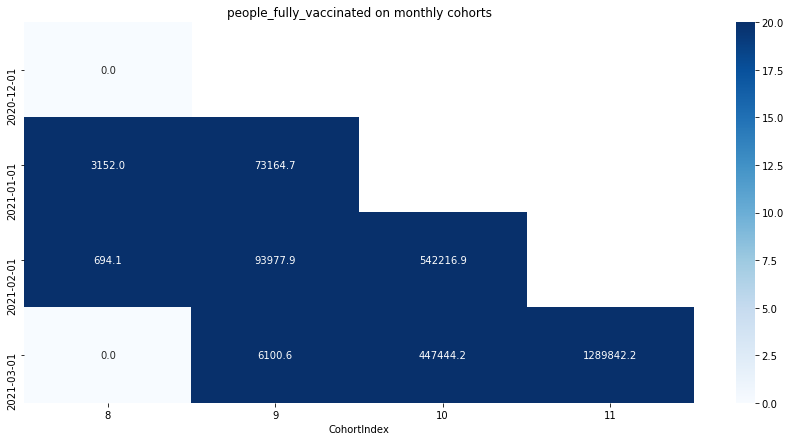

In [8]:
#mean quantity on cohorts

grouping = vax.groupby(['VaxedMonth', 'CohortIndex'])
cohort_data = grouping['people_fully_vaccinated'].mean()
cohort_data=cohort_data.reset_index()
avg_q=cohort_data.pivot(index='VaxedMonth', columns='CohortIndex', values='people_fully_vaccinated')
avg_q.round(1)
avg_q.index=avg_q.index.date

plt.figure(figsize=(15,7))
plt.title('people_fully_vaccinated on monthly cohorts')
sns.heatmap(data=avg_q, annot=True, vmin=0.0,  fmt = '.1f', vmax=20, cmap='Blues')
plt.show()


Cohorts based on vaccines

In [9]:
#count monthly cohs

grouping = vax.groupby(['VaxedMonth', 'CohortIndex'])
cohort_data_v = grouping['vaccines'].apply(pd.Series.nunique)

#return number of unique vals
cohort_data_v = cohort_data_v.reset_index()
cohort_counts = cohort_data_v.pivot(index='VaxedMonth', columns='CohortIndex', values='vaccines')
print(cohort_counts)

CohortIndex    8     9     10    11
VaxedMonth                         
2020-12-01  13.00   nan   nan   nan
2021-01-01  15.00 13.00   nan   nan
2021-02-01  16.00 13.00 13.00   nan
2021-03-01   3.00 16.00 13.00 13.00


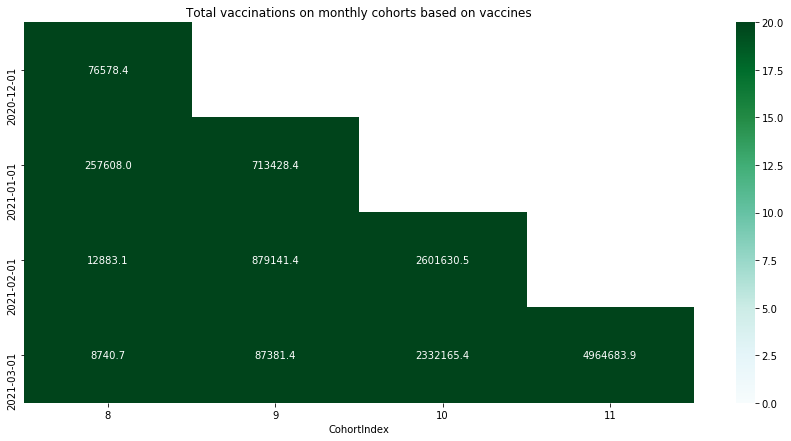

In [10]:
grouping = vax.groupby(['VaxedMonth', 'CohortIndex'])
cohort_data_v = grouping['total_vaccinations'].mean()
cohort_data_v=cohort_data_v.reset_index()
avg_q=cohort_data_v.pivot(index='VaxedMonth', columns='CohortIndex', values='total_vaccinations')
avg_q.round(1)
avg_q.index=avg_q.index.date

plt.figure(figsize=(15,7))
plt.title('Total vaccinations on monthly cohorts based on vaccines')
sns.heatmap(data=avg_q, annot=True, vmin=0.0,  fmt = '.1f', vmax=20, cmap='BuGn')
plt.show()

First 15 world countries that have fully vaccinated their people 

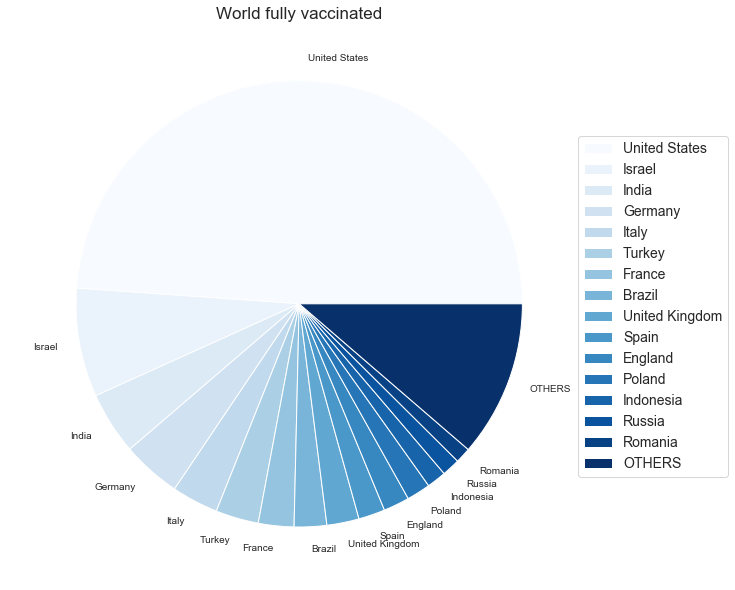

In [11]:
sns.set_style("whitegrid")
df = vax.groupby('country').agg({'people_fully_vaccinated': 'sum'}).sort_values('people_fully_vaccinated', ascending=False)

OTHERS = df.iloc[15:].sum()
df.drop(df.iloc[15:].index.tolist(), inplace=True)
df.loc['OTHERS'] = OTHERS


ax = df.plot.pie(y='people_fully_vaccinated', figsize=(10,20), colormap='Blues')
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, bbox_to_anchor=(1.0, 0.8), loc=2, borderaxespad=0., fontsize=14)
plt.ylabel(' ')
plt.title('World fully vaccinated', fontsize=17)
plt.show()

Vaccines

Distribution of vaccine sequence

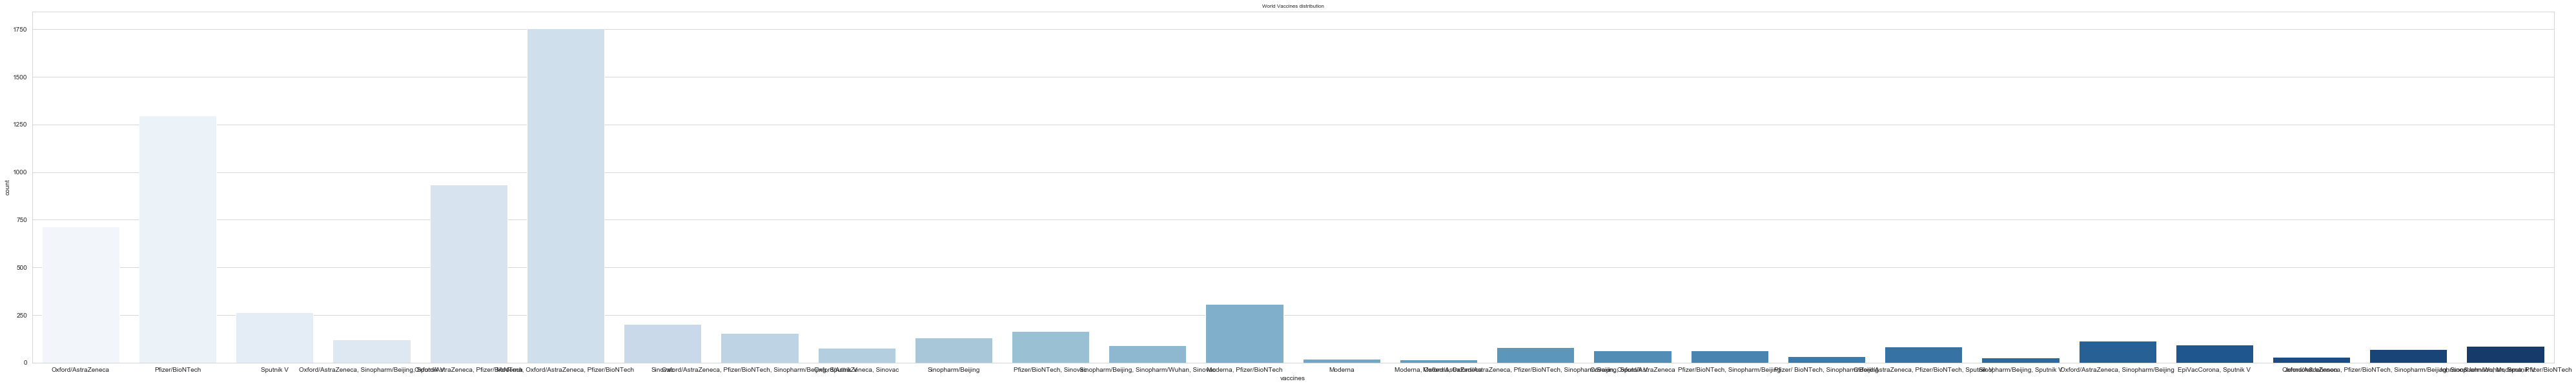

In [12]:
# distribution bar

plt.rcParams['figure.figsize'] = (70, 10)
sns.countplot(vax['vaccines'], palette = 'Blues')
plt.title('World Vaccines distribution', fontsize = 8)
plt.show()

                country iso_code  total_vaccinations  people_vaccinated  \
date                                                                      
2020-12-27      Romania      ROU                 965                965   
2020-12-28      Romania      ROU                2066               2066   
2020-12-29      Romania      ROU                2778               2778   
2020-12-30      Romania      ROU                5666               5666   
2020-12-31      Romania      ROU               10289              10289   
...                 ...      ...                 ...                ...   
2021-03-10  Netherlands      NLD                   0                  0   
2021-03-11  Netherlands      NLD                   0                  0   
2021-03-12  Netherlands      NLD                   0                  0   
2021-03-13  Netherlands      NLD                   0                  0   
2021-03-14  Netherlands      NLD             1887726            1394603   

            people_fully

In [13]:
v=vax.groupby(['vaccines'])['people_fully_vaccinated'].mean()
days=pd.DataFrame(data=v)
vaccination_bar=days.sort_values(by='people_fully_vaccinated',ascending=False,axis=0)
print(vaccination_bar)

fig = px.bar(vaccination_bar, x="people_fully_vaccinated", y=vaccination_bar.index, color='people_fully_vaccinated',color_continuous_scale='Blues',title="Vaccine order")
#plotly.offline.plot(fig, filename='v')

                                                    people_fully_vaccinated
vaccines                                                                   
Johnson&Johnson, Moderna, Pfizer/BioNTech                       11197725.19
Covaxin, Oxford/AstraZeneca                                      1475471.18
Oxford/AstraZeneca, Sinovac                                       623594.75
Moderna, Pfizer/BioNTech                                          572626.30
Sinovac                                                           448293.33
EpiVacCorona, Sputnik V                                           282690.15
Moderna, Oxford/AstraZeneca, Pfizer/BioNTech                      224027.03
Oxford/AstraZeneca, Pfizer/BioNTech, Sputnik V                    170237.26
Oxford/AstraZeneca, Sinopharm/Beijing                             129987.05
Moderna, Oxford/AstraZeneca, Pfizer/BioNTech, S...                127482.40
Pfizer/BioNTech, Sinovac                                          124993.64
Oxford/Astra

In [14]:
#contingency no.of.jobs table 
Germany=vax[vax.country=='Germany']

hourly=['iso_code', 'vaccines']
cm=sns.colormap='Blues'
pd.crosstab(Germany[hourly[0]], Germany[hourly[1]], values=Germany['people_fully_vaccinated'], margins=False, aggfunc='sum').fillna(0).style.background_gradient(cmap=cm)

vaccines,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech"
iso_code,
DEU,86226307


In [15]:
#contingency no.of.jobs table 

hourly=['iso_code', 'vaccines']
cm=sns.colormap='Blues'
pd.crosstab(Romania[hourly[0]], Romania[hourly[1]], values=Romania['people_fully_vaccinated'], margins=False, aggfunc='sum').fillna(0).style.background_gradient(cmap=cm)

vaccines,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech"
iso_code,
ROU,22634382


                country iso_code  total_vaccinations  people_vaccinated  \
date                                                                      
2020-12-27      Romania      ROU                 965                965   
2020-12-28      Romania      ROU                2066               2066   
2020-12-29      Romania      ROU                2778               2778   
2020-12-30      Romania      ROU                5666               5666   
2020-12-31      Romania      ROU               10289              10289   
...                 ...      ...                 ...                ...   
2021-03-10  Netherlands      NLD                   0                  0   
2021-03-11  Netherlands      NLD                   0                  0   
2021-03-12  Netherlands      NLD                   0                  0   
2021-03-13  Netherlands      NLD                   0                  0   
2021-03-14  Netherlands      NLD             1887726            1394603   

            people_fully

Fully vaccinated people's distribution accross world countries

<ipython-input-19-814c9d14359f>:2: RuntimeWarning:

divide by zero encountered in log



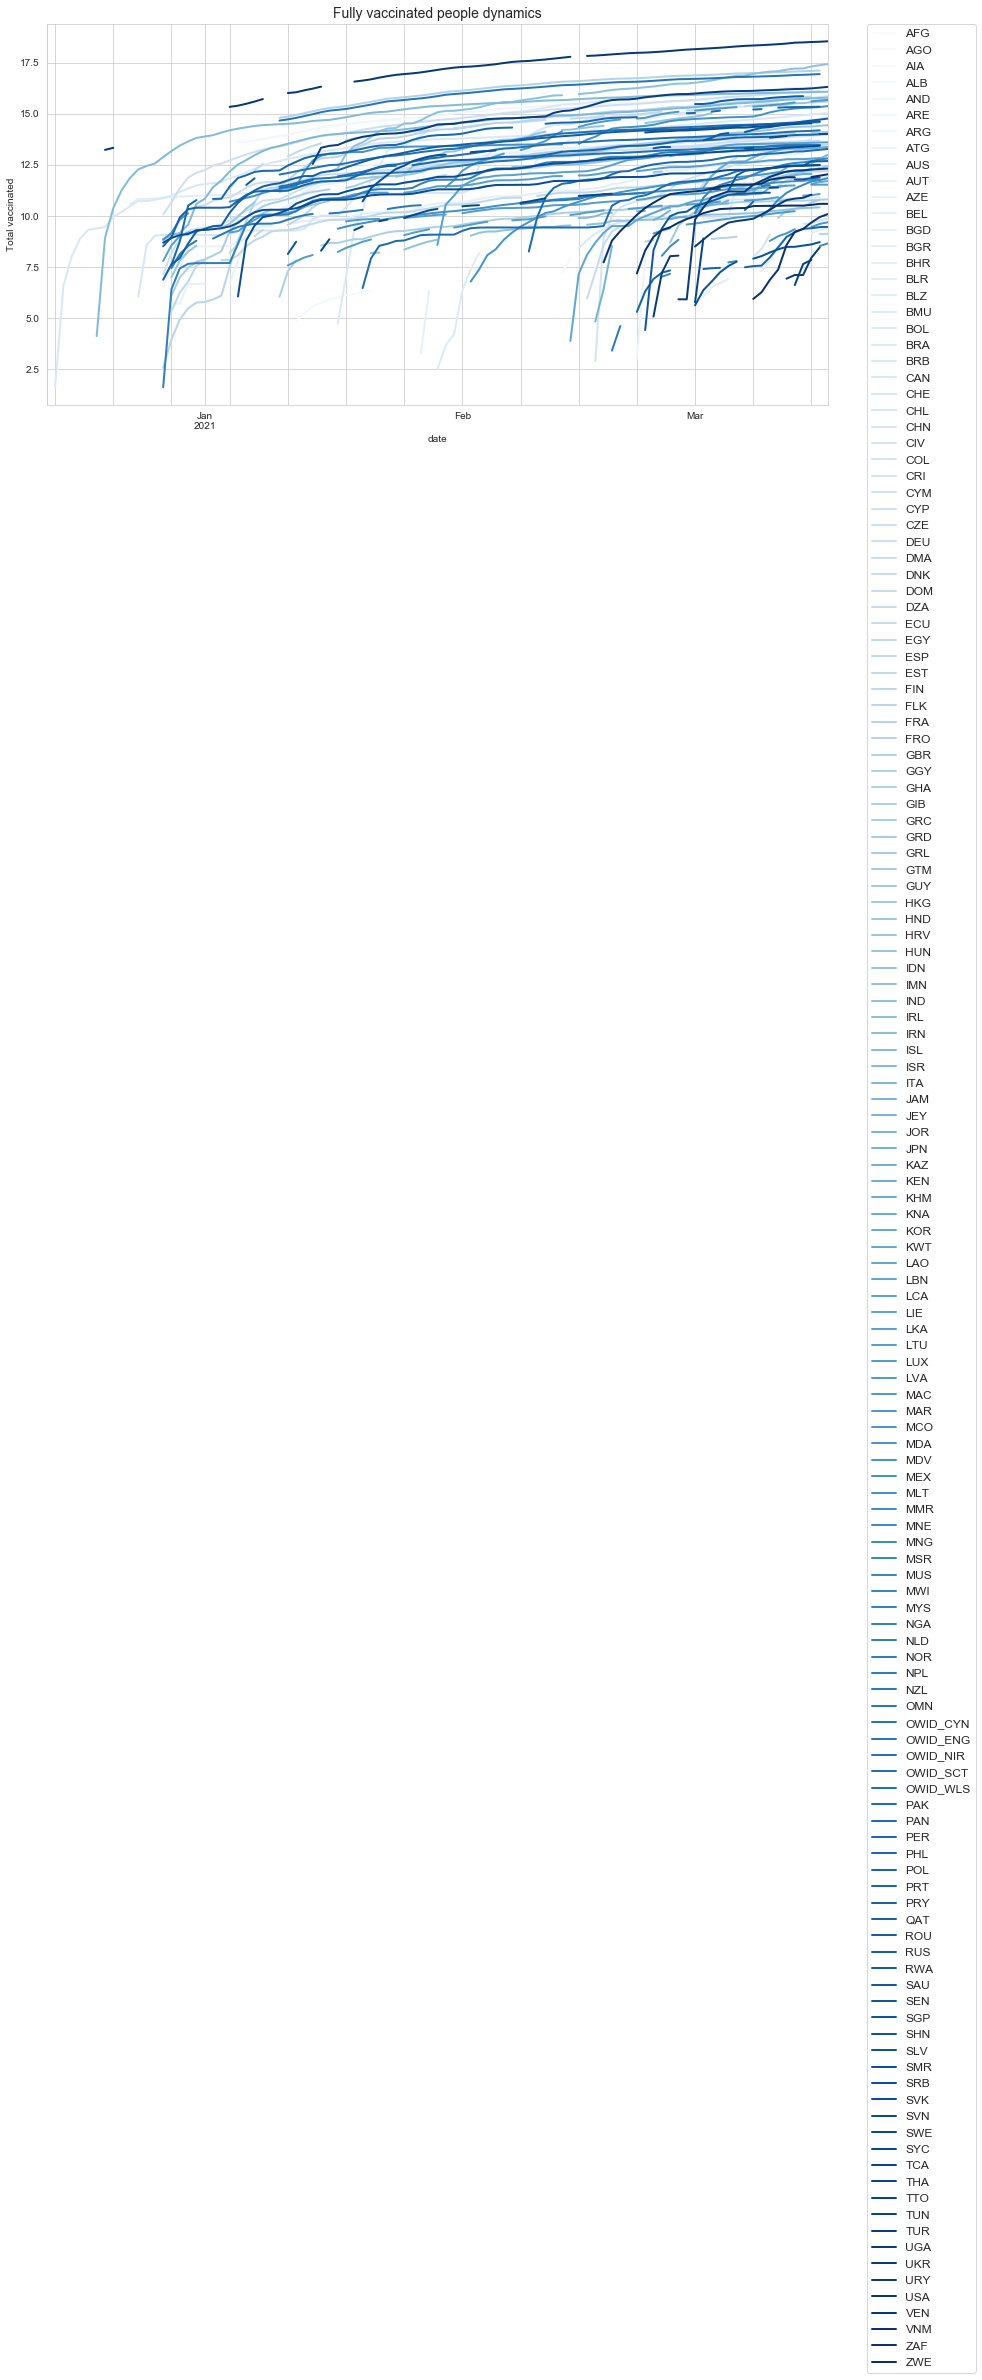

In [19]:
sns.set_style("whitegrid")
ax = np.log(vax.pivot( index='date',columns='iso_code', values='total_vaccinations')).plot(figsize=(14,7), colormap='Blues', linewidth=2)
lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
plt.title('Fully vaccinated people dynamics', fontsize=14)
plt.ylabel('Total vaccinated')
plt.grid(which='minor')
plt.show()



In [20]:
vax_path='EU_vaccs.csv'
vax_eu=pd.read_csv(vax_path)
print(vax_eu)


         country iso_code        date  total_vaccinations  people_vaccinated  \
0        Romania      ROU  12/27/2020                 965                965   
1        Romania      ROU  12/28/2020                2066               2066   
2        Romania      ROU  12/29/2020                2778               2778   
3        Romania      ROU  12/30/2020                5666               5666   
4        Romania      ROU  12/31/2020               10289              10289   
..           ...      ...         ...                 ...                ...   
369  Netherlands      NLD   3/10/2021                   0                  0   
370  Netherlands      NLD   3/11/2021                   0                  0   
371  Netherlands      NLD   3/12/2021                   0                  0   
372  Netherlands      NLD   3/13/2021                   0                  0   
373  Netherlands      NLD   3/14/2021             1887726            1394603   

     people_fully_vaccinated  daily_vac

In [21]:
#parse index
vax_eu['date']=pd.to_datetime(vax_eu['date'], infer_datetime_format=True)
indexeddf=vax_eu.set_index(['date'])
print(indexeddf)

                country iso_code  total_vaccinations  people_vaccinated  \
date                                                                      
2020-12-27      Romania      ROU                 965                965   
2020-12-28      Romania      ROU                2066               2066   
2020-12-29      Romania      ROU                2778               2778   
2020-12-30      Romania      ROU                5666               5666   
2020-12-31      Romania      ROU               10289              10289   
...                 ...      ...                 ...                ...   
2021-03-10  Netherlands      NLD                   0                  0   
2021-03-11  Netherlands      NLD                   0                  0   
2021-03-12  Netherlands      NLD                   0                  0   
2021-03-13  Netherlands      NLD                   0                  0   
2021-03-14  Netherlands      NLD             1887726            1394603   

            people_fully

In [22]:

#parsing to time format and extracting dates with 'created_at'
x=vax_eu['date']=pd.to_datetime(vax_eu['date'], format='%d-%m-%y')

Day=vax_eu['date'].dt.day_name()
Month=vax_eu['date'].dt.month_name()
Year=vax_eu['date'].dt.year

#subsetting 
vax_eu['Year']=vax_eu['date'].dt.year
vax_eu['Month']=vax_eu['date'].dt.month_name()
vax_eu['Day']=vax_eu['date'].dt.day_name()
print(vax_eu)

         country iso_code       date  total_vaccinations  people_vaccinated  \
0        Romania      ROU 2020-12-27                 965                965   
1        Romania      ROU 2020-12-28                2066               2066   
2        Romania      ROU 2020-12-29                2778               2778   
3        Romania      ROU 2020-12-30                5666               5666   
4        Romania      ROU 2020-12-31               10289              10289   
..           ...      ...        ...                 ...                ...   
369  Netherlands      NLD 2021-03-10                   0                  0   
370  Netherlands      NLD 2021-03-11                   0                  0   
371  Netherlands      NLD 2021-03-12                   0                  0   
372  Netherlands      NLD 2021-03-13                   0                  0   
373  Netherlands      NLD 2021-03-14             1887726            1394603   

     people_fully_vaccinated  daily_vaccinations_ra

In [32]:


df=vax[['date','people_fully_vaccinated', 'country','daily_vaccinations']]
# Set the width and height of the figure
df


,date,people_fully_vaccinated,country,daily_vaccinations
0,2021-02-22,0,Afghanistan,0
1,2021-02-23,0,Afghanistan,1367
2,2021-02-24,0,Afghanistan,1367
3,2021-02-25,0,Afghanistan,1367
4,2021-02-26,0,Afghanistan,1367
...,...,...,...,...
6993,2021-03-13,0,Zimbabwe,621
6994,2021-03-14,0,Zimbabwe,588
6995,2021-03-15,0,Zimbabwe,306
6996,2021-03-16,0,Zimbabwe,541


In [59]:
v=vax_eu.groupby(['vaccines'])['people_fully_vaccinated'].sum()
days=pd.DataFrame(data=v)
vaccination_bar=days.sort_values(by='people_fully_vaccinated',ascending=False)
print(vaccination_bar)

                                              people_fully_vaccinated
vaccines                                                             
Moderna, Oxford/AstraZeneca, Pfizer/BioNTech                162751120


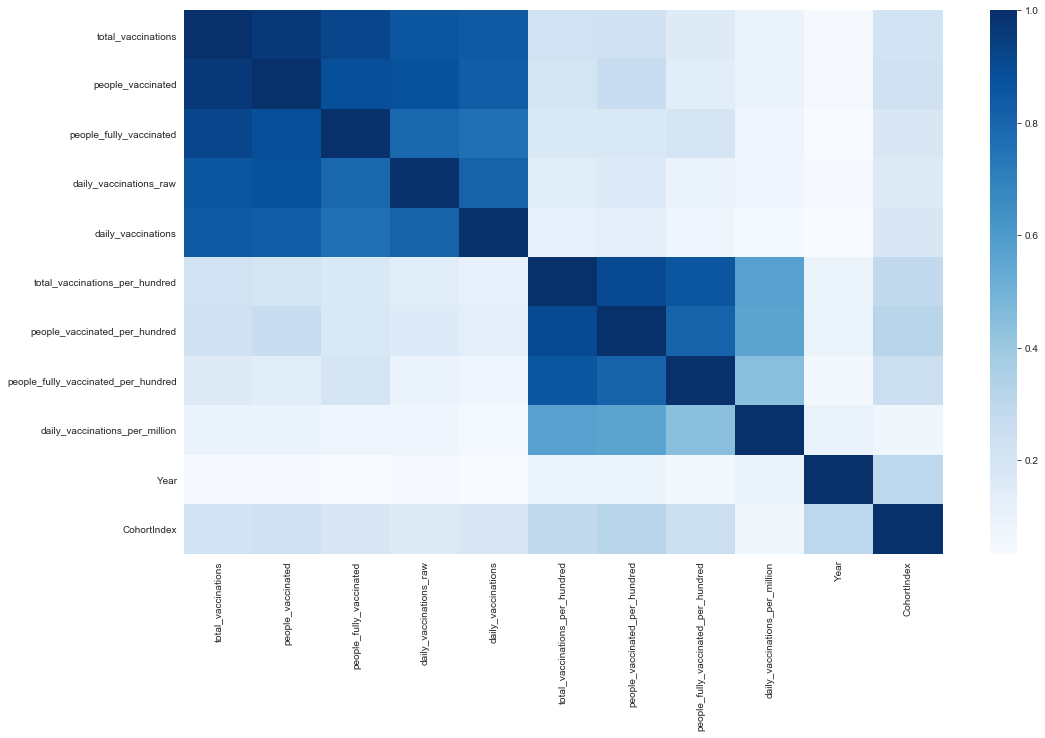

In [62]:
#heatmap
plt.figure(figsize=(17,10))
sns.heatmap(vax.corr(),cmap='Blues')
plt.show()

In [84]:
v=vax_eu.groupby(['country'])['people_fully_vaccinated'].mean()
days=pd.DataFrame(data=v)
vaccination_bar=days.sort_values(by='people_fully_vaccinated',ascending=False,axis=0)
print(vaccination_bar)

fig = px.bar(vaccination_bar, x="people_fully_vaccinated", y=vaccination_bar.index, color='people_fully_vaccinated',color_continuous_scale='Blues',title="Fully vaccinated in European countries ")
plotly.offline.plot(fig, filename='v')

             people_fully_vaccinated
country                             
Germany                   1077828.84
France                     656988.14
Romania                    282929.78
Netherlands                 29172.21
Luxembourg                   3849.09
C:\Users\sf\AppData\Local\Programs\Python\Python38-32\lib\site-packages\plotly\offline\offline.py:562: UserWarning:

Your filename `v` didn't end with .html. Adding .html to the end of your file.



'v.html'

    Treemap on vaccine scheme

In [80]:
fig = px.treemap(vax, path = ['vaccines', 'country'], values = 'people_fully_vaccinated', color_continuous_scale="Teal",
                title="Fully vaccinated per country grouped by vaccine scheme")

plotly.offline.plot(fig, filename='v')

'v.html'

In [82]:
fig = px.treemap(vax, path = ['vaccines', 'country'], values = 'total_vaccinations', color_continuous_scale="Teal",
                title="Total vaccinations by country by vaccination scheme")

plotly.offline.plot(fig, filename='v')

'v.html'

In [90]:
c=vax[['country','daily_vaccinations','people_fully_vaccinated_per_hundred']].copy()